## Image Preprocessing

In this notebook a set of input images are transformed in various ways in order to increase the robustness of the model.
The following transforms are made:
1. Addition of Image noise, this is done by adding some random noise from one of three background images (locations where shoes might be pictured)
2. Image Rotation; Images are rotatated 3 times with different background noise added on each rotation.
3. Image Scaling; Images are scaled, again with different background noise added.

In [2]:
import pandas as pd
from PIL import Image
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
import random as rand
import cv2
%matplotlib inline

In [3]:
## Read in Shoe IDs and Shoe types
Data=pd.read_csv('Shoe_IDs.csv')

In [7]:
Data=Data.drop('Unnamed: 0',axis=1)
Data.head()

,id,type_1,type_2,Model_1,Red,Green,Blue,Red_2,Green_2,Blue_2,Red_3,Green_3,Blue_3,ID
0,10401,sneakers,NaN,sneakers,62,58,62,190,189,191,130,129,131,10401
1,1557,sneakers,NaN,sneakers,51,49,57,107,106,108,29,28,33,1557
2,1558,boots,chelsea,boots,170,112,73,125,79,46,197,141,106,1558
3,1559,boots,NaN,boots,179,152,126,77,62,53,154,125,100,1559
4,1560,boots,chelsea,boots,25,21,21,88,86,86,46,42,42,1560


In [8]:
## Read in Shoe IDs and Shoe types from the second round of scraping
Data2=pd.read_csv('Shoe_IDs_2.csv')

In [9]:
Data2=Data2.drop('Unnamed: 0',axis=1)
Data2.head()

,description,image_url,price,shoe_type,id,Model_1
0,ASOS Boat Shoes in Tan Leather,http://images.asos-media.com/inv/media/7/9/5/8...,40.00,Boat,12809,loafers
1,River Island Leather Driver Shoes In Tan,http://images.asos-media.com/inv/media/4/0/6/9...,45.00,Boat,12810,loafers
2,River Island Leather Woven Boat Shoes In Brown,http://images.asos-media.com/inv/media/3/8/3/0...,45.00,Boat,12811,loafers
3,River Island Leather Boat Shoes In Navy And Brown,http://images.asos-media.com/inv/media/4/7/3/0...,45.00,Boat,12812,loafers
4,Tommy Hilfiger Coast Boat Shoes,http://images.asos-media.com/inv/media/0/7/9/8...,115.00,Boat,12813,loafers


In [10]:
Root_Location='/Users/annacrawford/Desktop/Images_CNN/'

In [11]:
## Creating a list of all the shoe IDs
files=list(Data.id)
files=[''.join(['_',str(x),'_a.jpg']) for x in files]
Image_Order=[x[1:-6] for x in files]

In [12]:
## Creating a list of all the shoe IDs from the second data set
files2=list(Data2.id)
files2=[''.join(['_',str(x),'_a.jpg']) for x in files2]

In [13]:
## Combining all of the shoe ids to be processed
All_files=files+files2

In [14]:
## Creating a y list of all of the related classes
y=list(Data.Model_1)+list(Data2.Model_1)

In [15]:
len(y)

10845

In [16]:
## Opening the background images in gray scale, all the images will be processed in grayscale as the colour 
## should not determine the classification
Background1=Image.open('Background1.jpg').convert('L')
Background2=Image.open('Background2.jpg').convert('L')
Background3=Image.open('Background3.jpg').convert('L')
Background_List=[Background1,Background2,Background3]

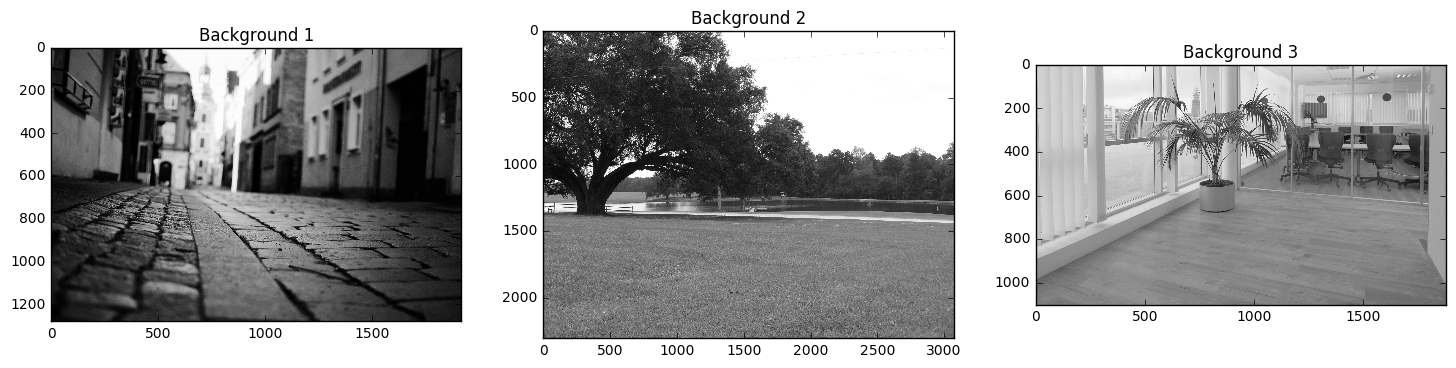

In [62]:
plt.figure(figsize = (18, 8))
plt.subplot(1, 3, 1)
plt.title('Background 1')
plt.imshow(Background1, cmap='gray')
plt.subplot(1, 3, 2)
plt.title('Background 2')
plt.imshow(Background2, cmap='gray')
plt.subplot(1, 3, 3)
plt.title('Background 3')
plt.imshow(Background3, cmap='gray')

In [17]:
## This function generates a randome 200x200 subsection of one of the three background images. it then places 
## this background behind any white pixels in the input image. The level of white is selected that only the studio 
## background should be replaced.
def Background_Generate(Input_Image):
    Background_Number=rand.randint(0,2)
    Background_Image=Background_List[Background_Number]
    ## Crop random area
    ar=misc.fromimage(Background_Image)
    h=ar.shape[0]
    w=ar.shape[1]
    y=rand.randint(0,h-200)
    x=rand.randint(0,w-200)
    Cropped_Image=Background_Image.crop((x,y,x+200,y+200))
    #Out_Image=Image.blend(Cropped_Image,im,0.5)
    ar_out=misc.fromimage(Cropped_Image)
    Output_Image=np.select([Input_Image<245],[Input_Image],ar_out)
    return Output_Image

In [18]:
## This funtion resizes the input image and outputs 2 scaled images, additonal white strips are used to ensure 
## the output image is still 200x200 pixels
def resize(Input_image):
    Med=cv2.resize(Input_image,(150,150))
    Small=cv2.resize(Input_image,(100,100))
    White_Small=np.empty((200,200),dtype=Med.dtype)
    White_Small.fill(255)
    White_Med=White_Small.copy()
    White_Small[50:150, 50:150] = Small
    White_Med[25:175, 25:175] = Med
    return White_Med,White_Small

In [19]:
## Creating blank lists that will be used to house all to the various transformed images.
Original_Image=[]
Background_Image=[]
Image_Rotate1=[]
Image_Rotate2=[]
Image_Rotate3=[]
Image_Scale1=[]
Image_Scale2=[]

## For each imput image, the image is transformed 6 times and appended to the various lists above.
for x in All_files:
    try:
        dloc=''.join([Root_Location,x])
        ## Import image in greyscale
        im = cv2.imread(dloc,0)

        ## Base Image
        Original_Image.append(im)

        ## Add Noise
        im_N=Background_Generate(im)
        Background_Image.append(im_N)

        ## Scale Image
        Med,Small=resize(im)

        ## Add Noise
        Med=Background_Generate(Med)
        Image_Scale1.append(Med)

        Small=Background_Generate(Small)
        Image_Scale2.append(Small)

        ## Noisy Image
        N_Im=Background_Generate(im)

        ## Rotate Noisy Image
        ar_90=np.rot90(N_Im,1)
        Image_Rotate1.append(ar_90)

        ar_180=np.rot90(N_Im,2)
        Image_Rotate2.append(ar_180)

        ar_270=np.rot90(N_Im,3)
        Image_Rotate3.append(ar_270)
    
    except:
        print 'Error processing image :',x

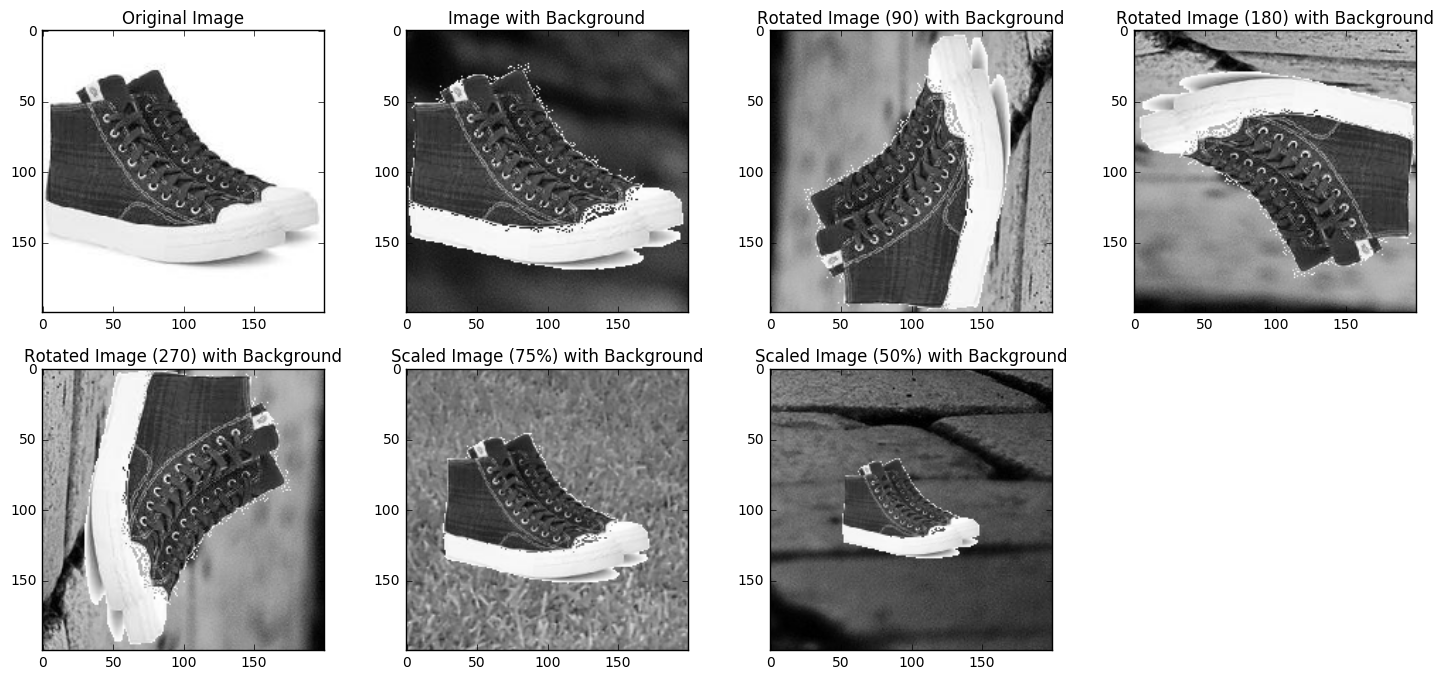

In [60]:
# Sample images
plt.figure(figsize = (18, 8))
plt.subplot(2, 4, 1)
plt.title('Original Image')
plt.imshow(Original_Image[501], cmap='gray')
plt.subplot(2, 4, 2)
plt.title('Image with Background')
plt.imshow(Background_Image[501], cmap='gray')
plt.subplot(2, 4, 3)
plt.title('Rotated Image (90) with Background')
plt.imshow(Image_Rotate1[501], cmap='gray')
plt.subplot(2, 4, 4)
plt.title('Rotated Image (180) with Background')
plt.imshow(Image_Rotate2[501], cmap='gray') 
plt.subplot(2, 4, 5)
plt.title('Rotated Image (270) with Background')
plt.imshow(Image_Rotate3[501], cmap='gray') 
plt.subplot(2, 4, 6)
plt.title('Scaled Image (75%) with Background')
plt.imshow(Image_Scale1[501], cmap='gray') 
plt.subplot(2, 4, 7)
plt.title('Scaled Image (50%) with Background')
plt.imshow(Image_Scale2[501], cmap='gray')
plt.show()

In [20]:
len(Original_Image)

10845

In [22]:
## Create an array of each of the lists combined together
X = np.concatenate([Original_Image,
            Background_Image,
            Image_Rotate1,
            Image_Rotate2,
            Image_Rotate3,
            Image_Scale1,
            Image_Scale2])

In [23]:
X.shape

(75915, 200, 200)

In [24]:
## Write the X array to file to be run on the AWS ec2 instance
with file('X_Data_Large_2.npy', 'w') as Xoutfile:
    np.save(Xoutfile,X)

In [32]:
## Create a list of 7 times the 7 classes
out_y=y+y+y+y+y+y+y

In [33]:
## Create a list of the appended lists
out_y=np.array(out_y)

In [34]:
out_y.shape

(75915,)

In [36]:
## Write the y array to file to be run on the AWS ec2 instance
with file('y_Data_Large_2.npy', 'w') as youtfile:    
    np.save(youtfile,out_y)